# Week 12.3 - Topic Modelling using LDA

## Preparation

In this exercise, we will need to make sure the following packages are installed into your conda environment that runs this Jupyter notebook. 

`pip install gensim spacy pyLDAvis matplotlib numpy pandas nltk`

Note: This notebook takes approximately 50 minutes to execute all cells. The visualisations of the topic models is the culprit.

In [ ]:
!pip install gensim spacy pyLDAvis matplotlib numpy pandas

In [1]:
# For Google Drive mounting
# from google.colab import drive

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

### Define stop words

In [3]:
# Need to download stopwords before they can be used
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\22917746\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
pprint(stop_words)

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

### Import the GSWA dataset

The 20-Newsgroups dataset contains about 6k data posts from 1,135 GSWA reports. 

The dataset can be imported using `pandas.read_json` and we can see the dataset has 3 columns. The `target-name` is the category or topics that the news is manually assigned to. 

We choose to use this dataset because it has pre-assigned categories according to topics, so our clustering results can be readily compared. In real world data, this is not always easily available. 

In [5]:
import zipfile
import json
# Import Dataset

data_path = r"../data/wamex_xml.zip"

data = list()
with zipfile.ZipFile(data_path, "r") as z:
    #df = [pd.read_json(filename) for filename in z.namelist()]
    print(len(z.namelist()))
    for filename in z.namelist():
        # print(filename)
        # df = pd.read_json(filename)
        with z.open(filename) as f:
            # load the json file
            # The resulting `content` is a list
            content = json.loads(f.read()) 
            # Convert content to a string   
            content = "".join(content)
            # Add to the data list
            data.append(content)

1135


In [6]:
pprint(data[:1])

['Combined Reporting Application Pending Status: Sheet 1:250 000: Kalgoorlie '
 '(SH 51-09) Sheet 1:100 000: Kalgoorlie (3136) Project Operator: Cazaly '
 'Resources Limited Author: M Watts Date: September 2006 Distribution: '
 '1.Department of Industry and Resources 2.Cazaly Resources Limited Cazaly '
 'Resources Limited September 2006 2 Figure 2: Castle Hill Project Tenement '
 'Location Plan, 1: 75 000 scale 6 Figure 3: Regional Geology with Exploration '
 'Index Map, 1:75 000 scale 8Cazaly Resources Limited September 2006 3 1.0 '
 'SUMMARY The Combined Mineral Exploration Report on the Castle Hill Project '
 'details exploration activities undertaken by Cazaly Resources Limited during '
 'the reporting period from 7 July 2005 to 6 July 2006.The reporting group '
 'known as Castle Hill comprises nine granted prospecting licences.The project '
 'area covers some 1250 hectares.Cazaly is the registered holder of the Castle '
 'Hill Project tenements.Cazalys exploration activities durin

## Pre-processing
### Removing unnecessary information

We can use regular expressions for this purpose by untilising the `re` package.

In [7]:
# Remove Figure No. 
data = [re.sub('Figure\s+\d+', '', sent) for sent in data]

# Remove all numbers
data = [re.sub('\d+', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['Combined Reporting Application Pending Status: Sheet : : Kalgoorlie (SH -) '
 'Sheet : : Kalgoorlie () Project Operator: Cazaly Resources Limited Author: M '
 'Watts Date: September Distribution: .Department of Industry and Resources '
 '.Cazaly Resources Limited Cazaly Resources Limited September : Castle Hill '
 'Project Tenement Location Plan, : scale : Regional Geology with Exploration '
 'Index Map, : scale Cazaly Resources Limited September . SUMMARY The Combined '
 'Mineral Exploration Report on the Castle Hill Project details exploration '
 'activities undertaken by Cazaly Resources Limited during the reporting '
 'period from July to July .The reporting group known as Castle Hill comprises '
 'nine granted prospecting licences.The project area covers some '
 'hectares.Cazaly is the registered holder of the Castle Hill Project '
 'tenements.Cazalys exploration activities during the reporting period have '
 'been directed towards the acquisition of available reports and datase

### Tokenisation

We need to break down each sentence into a list of words, for the data to be ready for consumption by `gensim`. The `simple_preprocess()` function is built for such purposes. We can also set the `deacc=True` to remove punctuations. 

In [8]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [9]:
data_words = list(sent_to_words(data))

pprint(data_words[:1])

[['combined',
  'reporting',
  'application',
  'pending',
  'status',
  'sheet',
  'kalgoorlie',
  'sh',
  'sheet',
  'kalgoorlie',
  'project',
  'operator',
  'cazaly',
  'resources',
  'limited',
  'author',
  'watts',
  'date',
  'september',
  'distribution',
  'department',
  'of',
  'industry',
  'and',
  'resources',
  'cazaly',
  'resources',
  'limited',
  'cazaly',
  'resources',
  'limited',
  'september',
  'castle',
  'hill',
  'project',
  'tenement',
  'location',
  'plan',
  'scale',
  'regional',
  'geology',
  'with',
  'exploration',
  'index',
  'map',
  'scale',
  'cazaly',
  'resources',
  'limited',
  'september',
  'summary',
  'the',
  'combined',
  'mineral',
  'exploration',
  'report',
  'on',
  'the',
  'castle',
  'hill',
  'project',
  'details',
  'exploration',
  'activities',
  'undertaken',
  'by',
  'cazaly',
  'resources',
  'limited',
  'during',
  'the',
  'reporting',
  'period',
  'from',
  'july',
  'to',
  'july',
  'the',
  'reporting',
  '

### Creating bigram and trigrams - Gensim’s Phrases model

Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [10]:
%timeit
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

In [11]:
%timeit
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
# See trigram example
pprint(trigram_mod[bigram_mod[data_words[0]]])

['combined_reporting',
 'application',
 'pending',
 'status',
 'sheet',
 'kalgoorlie',
 'sh',
 'sheet',
 'kalgoorlie',
 'project',
 'operator',
 'cazaly',
 'resources',
 'limited',
 'author',
 'watts',
 'date',
 'september',
 'distribution',
 'department',
 'of',
 'industry',
 'and',
 'resources',
 'cazaly',
 'resources',
 'limited',
 'cazaly',
 'resources',
 'limited',
 'september',
 'castle_hill',
 'project',
 'tenement',
 'location',
 'plan',
 'scale',
 'regional',
 'geology',
 'with',
 'exploration',
 'index_map',
 'scale',
 'cazaly',
 'resources',
 'limited',
 'september',
 'summary',
 'the',
 'combined',
 'mineral',
 'exploration',
 'report',
 'on',
 'the',
 'castle_hill',
 'project',
 'details',
 'exploration',
 'activities',
 'undertaken',
 'by',
 'cazaly',
 'resources',
 'limited',
 'during',
 'the',
 'reporting_period',
 'from',
 'july',
 'to',
 'july',
 'the',
 'reporting',
 'group',
 'known',
 'as',
 'castle_hill',
 'comprises',
 'nine',
 'granted_prospecting_licences',
 't

### Build functions for the pre-processing pipeline

Remove stopwords, make bigram and trigrams, and lemmatisation.

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

### Call the functions in order

In [14]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

#### Caution on the lemmatiser

During the processing of the data, we realised that some documents is empty. We also know that the lemmatiser has a restriction on processing text no longer than 1000000 characters. So let's filter those documents out. 

In [15]:
index = 0
print(len(data_words_bigrams))

for text in data_words_bigrams:
    doc = " ".join(text)
    #print(len(doc))
    if(len(doc)==0 or len(doc)>1000000):
        data_words_bigrams.pop(index)
        
    index += 1

1135


In [16]:
print(len(data_words_bigrams))

934


In [19]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# !python -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [20]:
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['combined', 'reporting', 'application', 'pende', 'status', 'sheet', 'sh', 'sheet', 'limited', 'author', 'date', 'distribution', 'department', 'industry', 'resource', 'resource', 'resource', 'limit', 'project', 'tenement', 'location', 'plan', 'scale', 'regional', 'geology', 'exploration', 'scale', 'resource', 'limit', 'summary', 'combine', 'report', 'project', 'detail', 'exploration', 'activity', 'undertake', 'resource', 'limit', 'report', 'group', 'know', 'comprise', 'grant', 'prospecting_licences', 'project', 'area', 'cover', 'project', 'tenement', 'exploration', 'activity', 'acquisition', 'available', 'report', 'dataset', 'relate', 'previous', 'exploration', 'activity', 'project', 'area', 'assess', 'gold', 'nickel', 'potential', 'project', 'area', 'follow', 'datum', 'review', 'project', 'rate', 'highly', 'nearby', 'project', 'area', 'manage', 'cazaly', 'introduction', 'combine', 'mineral', 'report', 'project', 'detail', 'exploration', 'work', 'undertake', 'limit', 'project', 'area'

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [22]:
# View
print(corpus[:1])

[[(0, 1), (1, 3), (2, 8), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 17), (10, 3), (11, 1), (12, 4), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 3), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 2), (33, 1), (34, 1), (35, 3), (36, 2), (37, 3), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 4), (45, 1), (46, 1), (47, 1), (48, 11), (49, 1), (50, 1), (51, 1), (52, 3), (53, 1), (54, 2), (55, 1), (56, 1), (57, 3), (58, 1), (59, 1), (60, 1), (61, 5), (62, 4), (63, 2), (64, 1), (65, 1), (66, 1), (67, 4), (68, 1), (69, 1), (70, 2), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 4), (82, 1), (83, 4), (84, 6), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 5), (91, 2), (92, 1), (93, 2), (94, 2), (95, 1), (96, 1), (97, 3), (98, 6), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 3), (107, 1), (108, 1), (109, 1), (110, 

In [23]:
print(corpus[2])

[(37, 1), (45, 2), (48, 1), (94, 1), (121, 1), (123, 1), (127, 1), (169, 1), (203, 1), (226, 1), (322, 1), (337, 1), (357, 1), (373, 1), (380, 1), (436, 1), (483, 2), (526, 1), (542, 1), (561, 1), (570, 1), (577, 1), (613, 2), (722, 1), (750, 1), (785, 1), (790, 1), (836, 1), (908, 1), (912, 1), (962, 1), (963, 1), (964, 1), (965, 1), (966, 1), (967, 1), (968, 1), (969, 1), (970, 1), (971, 1), (972, 1), (973, 1), (974, 1), (975, 1), (976, 1), (977, 4), (978, 1), (979, 3), (980, 1), (981, 1)]


In [24]:
print(texts[0])

['combined', 'reporting', 'application', 'pende', 'status', 'sheet', 'sh', 'sheet', 'limited', 'author', 'date', 'distribution', 'department', 'industry', 'resource', 'resource', 'resource', 'limit', 'project', 'tenement', 'location', 'plan', 'scale', 'regional', 'geology', 'exploration', 'scale', 'resource', 'limit', 'summary', 'combine', 'report', 'project', 'detail', 'exploration', 'activity', 'undertake', 'resource', 'limit', 'report', 'group', 'know', 'comprise', 'grant', 'prospecting_licences', 'project', 'area', 'cover', 'project', 'tenement', 'exploration', 'activity', 'acquisition', 'available', 'report', 'dataset', 'relate', 'previous', 'exploration', 'activity', 'project', 'area', 'assess', 'gold', 'nickel', 'potential', 'project', 'area', 'follow', 'datum', 'review', 'project', 'rate', 'highly', 'nearby', 'project', 'area', 'manage', 'cazaly', 'introduction', 'combine', 'mineral', 'report', 'project', 'detail', 'exploration', 'work', 'undertake', 'limit', 'project', 'area',

In [25]:
print(corpus[0])

[(0, 1), (1, 3), (2, 8), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 17), (10, 3), (11, 1), (12, 4), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 2), (19, 1), (20, 1), (21, 1), (22, 1), (23, 3), (24, 2), (25, 2), (26, 1), (27, 1), (28, 1), (29, 2), (30, 1), (31, 2), (32, 2), (33, 1), (34, 1), (35, 3), (36, 2), (37, 3), (38, 1), (39, 1), (40, 3), (41, 1), (42, 1), (43, 1), (44, 4), (45, 1), (46, 1), (47, 1), (48, 11), (49, 1), (50, 1), (51, 1), (52, 3), (53, 1), (54, 2), (55, 1), (56, 1), (57, 3), (58, 1), (59, 1), (60, 1), (61, 5), (62, 4), (63, 2), (64, 1), (65, 1), (66, 1), (67, 4), (68, 1), (69, 1), (70, 2), (71, 1), (72, 2), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 2), (81, 4), (82, 1), (83, 4), (84, 6), (85, 1), (86, 1), (87, 1), (88, 1), (89, 2), (90, 5), (91, 2), (92, 1), (93, 2), (94, 2), (95, 1), (96, 1), (97, 3), (98, 6), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 2), (106, 3), (107, 1), (108, 1), (109, 1), (110, 1

In [26]:
print(id2word[0])

accordingly


In [27]:
print(corpus[0][0])

(0, 1)


In [28]:
sorted_by_value = sorted(corpus[0], key=lambda kv: kv[1], reverse=True)
print(sorted_by_value)

[(114, 26), (9, 17), (48, 11), (153, 10), (2, 8), (123, 7), (126, 7), (84, 6), (98, 6), (125, 6), (160, 6), (61, 5), (90, 5), (111, 5), (12, 4), (44, 4), (62, 4), (67, 4), (81, 4), (83, 4), (121, 4), (124, 4), (1, 3), (10, 3), (23, 3), (35, 3), (37, 3), (40, 3), (52, 3), (57, 3), (97, 3), (106, 3), (112, 3), (117, 3), (122, 3), (127, 3), (131, 3), (140, 3), (4, 2), (7, 2), (18, 2), (24, 2), (25, 2), (29, 2), (31, 2), (32, 2), (36, 2), (54, 2), (63, 2), (70, 2), (72, 2), (80, 2), (89, 2), (91, 2), (93, 2), (94, 2), (105, 2), (115, 2), (128, 2), (133, 2), (134, 2), (135, 2), (137, 2), (141, 2), (155, 2), (159, 2), (162, 2), (171, 2), (0, 1), (3, 1), (5, 1), (6, 1), (8, 1), (11, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (19, 1), (20, 1), (21, 1), (22, 1), (26, 1), (27, 1), (28, 1), (30, 1), (33, 1), (34, 1), (38, 1), (39, 1), (41, 1), (42, 1), (43, 1), (45, 1), (46, 1), (47, 1), (49, 1), (50, 1), (51, 1), (53, 1), (55, 1), (56, 1), (58, 1), (59, 1), (60, 1), (64, 1), (65, 1), (66, 

In [29]:
# Human readable format of corpus (term-frequency)
[(id2word[id], freq) for id, freq in sorted_by_value] 

[('project', 26),
 ('area', 17),
 ('exploration', 11),
 ('tenement', 10),
 ('activity', 8),
 ('report', 7),
 ('review', 7),
 ('limit', 6),
 ('nickel', 6),
 ('resource', 6),
 ('ultramafic', 6),
 ('geology', 5),
 ('mafic', 5),
 ('potential', 5),
 ('available', 4),
 ('domain', 4),
 ('gold', 4),
 ('group', 4),
 ('kunanalle', 4),
 ('lie', 4),
 ('regional', 4),
 ('reporting', 4),
 ('acquisition', 3),
 ('assess', 3),
 ('combine', 3),
 ('dataset', 3),
 ('datum', 3),
 ('detail', 3),
 ('fault', 3),
 ('follow', 3),
 ('nearby', 3),
 ('part', 3),
 ('previous', 3),
 ('rate', 3),
 ('relate', 3),
 ('rock', 3),
 ('sequence', 3),
 ('structural', 3),
 ('adjacent', 2),
 ('application', 2),
 ('characterise', 2),
 ('combined', 2),
 ('comprise', 2),
 ('contact', 2),
 ('coolgardie', 2),
 ('cover', 2),
 ('date', 2),
 ('felsic', 2),
 ('grant', 2),
 ('highly', 2),
 ('immediately', 2),
 ('know', 2),
 ('low', 2),
 ('major', 2),
 ('manage', 2),
 ('mineral', 2),
 ('overlie', 2),
 ('prospecting_licences', 2),
 ('scal

## Train LDA Model
Number of topics is set to 10

In [30]:
%timeit
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [31]:
# Show Topics
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.017*"resource" + 0.013*"use" + 0.012*"grade" + 0.011*"pit" + '
  '0.009*"model" + 0.009*"sample" + 0.008*"hole" + 0.008*"estimate" + '
  '0.008*"drill" + 0.008*"datum"'),
 (1,
  '0.080*"survey" + 0.033*"datum" + 0.019*"magnetic" + 0.018*"use" + '
  '0.014*"coordinate" + 0.014*"line" + 0.009*"field" + 0.009*"model" + '
  '0.008*"value" + 0.008*"station"'),
 (2,
  '0.002*"lith" + 0.001*"wasl" + 0.001*"wad" + 0.000*"wadg" + 0.000*"ass" + '
  '0.000*"surv" + 0.000*"rabass" + 0.000*"rabcollar" + 0.000*"rabsurv" + '
  '0.000*"wadl"'),
 (3,
  '0.001*"wasg" + 0.000*"pdfliterature" + 0.000*"formatdrill" + 0.000*"ande" + '
  '0.000*"haft" + 0.000*"samplingtable" + 0.000*"pulverized" + '
  '0.000*"detailsa" + 0.000*"intruded" + 0.000*"pangolin"'),
 (4,
  '0.042*"report" + 0.030*"exploration" + 0.022*"company" + 0.017*"date" + '
  '0.016*"tenement" + 0.011*"mineral" + 0.011*"specify" + 0.011*"work" + '
  '0.011*"right" + 0.010*"activity"'),
 (5,
  '0.027*"area" + 0.018*"site" + 0.012*"su

In [32]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.578795512662207

Coherence Score:  0.4353164223836144


### Visualising LDA 

#### Wait, what am I looking at again?

There are a lot of moving parts in the visualization. Here's a brief summary:

On the left, there is a plot of the "distance" between all of the topics (labeled as the Intertopic Distance Map)
The plot is rendered in two dimensions according a multidimensional scaling (MDS) algorithm. Topics that are generally similar should be appear close together on the plot, while dissimilar topics should appear far apart.

The relative size of a topic's circle in the plot corresponds to the relative frequency of the topic in the corpus.

An individual topic may be selected for closer scrutiny by clicking on its circle, or entering its number in the "selected topic" box in the upper-left.

On the right, there is a bar chart showing top terms.
When no topic is selected in the plot on the left, the bar chart shows the top most "salient" terms in the corpus. A term's saliency is a measure of both how frequent the term is in the corpus and how "distinctive" it is in distinguishing between different topics.

When a particular topic is selected, the bar chart changes to show the top most "relevant" terms for the selected topic. The relevance metric is controlled by the parameter λλ, which can be adjusted with a slider above the bar chart.

Setting the λλ parameter close to 1.0 (the default) will rank the terms solely according to their probability within the topic.

Setting λλ close to 0.0 will rank the terms solely according to their "distinctiveness" or "exclusivity" within the topic — i.e., terms that occur only in this topic, and do not occur in other topics.

Setting λλ to values between 0.0 and 1.0 will result in an intermediate ranking, weighting term probability and exclusivity accordingly.

Rolling the mouse over a term in the bar chart on the right will cause the topic circles to resize in the plot on the left, to show the strength of the relationship between the topics and the selected term.

A more detailed explanation of the pyLDAvis visualization can be found here. Unfortunately, though the data used by gensim and pyLDAvis are the same, they don't use the same ID numbers for topics. If you need to match up topics in gensim's LdaMulticore object and pyLDAvis' visualization, you have to dig through the terms manually.

#### Analyzing our LDA model
The interactive visualization pyLDAvis produces is helpful for both:

Better understanding and interpreting individual topics, and Better understanding the relationships between the topics.

For (1), you can manually select each topic to view its top most freqeuent and/or "relevant" terms, using different values of the λλ parameter. This can help when you're trying to assign a human interpretable name or "meaning" to each topic.

For (2), exploring the Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.

#### Describing text with LDA
Beyond data exploration, one of the key uses for an LDA model is providing a compact, quantitative description of natural language text. Once an LDA model has been trained, it can be used to represent free text as a mixture of the topics the model learned from the original corpus. This mixture can be interpreted as a probability distribution across the topics, so the LDA representation of a paragraph of text might look like 50% Topic A, 20% Topic B, 20% Topic C, and 10% Topic D.

To use an LDA model to generate a vector representation of new text, you'll need to apply any text preprocessing steps you used on the model's training corpus to the new text, too. For our model, the preprocessing steps we used include:

Using spaCy to remove punctuation and lemmatize the text

- Applying our first-order phrase model to join word pairs
- Applying our second-order phrase model to join longer phrases
- Removing stopwords
- Creating a bag-of-words representation
- Once you've applied these preprocessing steps to the new text, it's ready to pass directly to the model to create an LDA representation. The lda_description(...) function will perform all these steps for us, including printing the resulting topical description of the input text.

##### Acknowledgement: https://www.kaggle.com/navinch/interesting-visualizations-lda-word2vec

In [33]:
%timeit
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

c:\users\22917746\appdata\local\programs\python\python36\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.183477  0.033643       1        1  28.638235
7      0.198528  0.008686       2        1  20.752144
0      0.110262  0.099506       3        1  17.302402
6      0.167951 -0.108498       4        1  15.448460
8      0.026920 -0.329243       5        1   6.149745
5      0.100200  0.043605       6        1   5.455140
1     -0.011044  0.158595       7        1   4.551107
4     -0.102741  0.158769       8        1   1.699173
2     -0.336937 -0.032548       9        1   0.002725
3     -0.336615 -0.032514      10        1   0.000866, topic_info=     Category          Freq         Term         Total  loglift  logprob
872   Default   7965.000000       survey   7965.000000  30.0000  30.0000
123   Default   8612.000000       report   8612.000000  29.0000  29.0000
48    Default   8462.000000  exploration   8462.000000  28.0000  28.0000
62    Default  11491.000000         gold  11491.000000  27.0000  27.0000
153   Default   8884.000000     tenement   8884.000000  26.0000  26.0000
...       ...           ...          ...           ...      ...      ...
8229  Topic10      0.000443  watercourse     23.488796   0.7776  -9.9908
3152  Topic10      0.000443       exotic     37.905094   0.2990  -9.9908
7602  Topic10      0.000443        miner     25.048748   0.7132  -9.9908
5256  Topic10      0.000443    essential     18.769918   1.0018  -9.9909
8287  Topic10      0.000443         tone     25.141811   0.7095  -9.9909

[748 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
5322      6  0.813948  aboriginal
5322      8  0.180432  aboriginal
174       1  0.504322      access
174       2  0.205596      access
174       3  0.030025      access
...     ...       ...         ...
171       1  0.131620        zone
171       2  0.373256        zone
171       3  0.086234        zone
171       4  0.363453        zone
171       5  0.045386        zone

[1587 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 8, 1, 7, 9, 6, 2, 5, 3, 4])

## How to find the best number of topics

In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
#         model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [39]:
%timeit
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

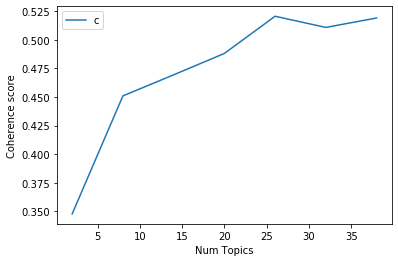

In [40]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()